In [ ]:
# TODO: Try randn instead of rand for the noise generator

In [ ]:
# Originally run in Google Colab

In [3]:
# Bash to download img_align_celeba.zip from the url:
# https://cseweb.ucsd.edu/~weijian/static/datasets/celeba/img_align_celeba.zip
!wget https://cseweb.ucsd.edu/~weijian/static/datasets/celeba/img_align_celeba.zip

--2022-11-16 13:17:06--  https://cseweb.ucsd.edu/~weijian/static/datasets/celeba/img_align_celeba.zip
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘img_align_celeba.zip’

img_align_celeba.zi 100%[===================>]   1.34G  4.25MB/s    in 4m 7s   

2022-11-16 13:21:14 (5.56 MB/s) - ‘img_align_celeba.zip’ saved [1443490838/1443490838]



In [4]:
!unzip -q img_align_celeba.zip

In [5]:
# Image folder needs to be in a subfolder for torchvision.dataset.ImageFolder
!mkdir data
!mv img_align_celeba data

In [6]:
# Get relevant utils.py file
!wget https://raw.githubusercontent.com/callummcdougall/arena-v1/main/w4d1/utils.py

--2022-11-16 13:21:36--  https://raw.githubusercontent.com/callummcdougall/arena-v1/main/w4d1/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9325 (9.1K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   9.11K  --.-KB/s    in 0s      

2022-11-16 13:21:37 (105 MB/s) - ‘utils.py’ saved [9325/9325]



In [1]:
# Install required packages
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 507 kB/s 


In [7]:
import torch as t
import torch.nn as nn
from torchvision import transforms, datasets

from typing import Tuple, Optional, Union
from collections import OrderedDict
from einops import rearrange
from einops.layers.torch import Rearrange
from tqdm.notebook import tqdm_notebook

import utils

In [8]:
class Generator(nn.Module):
    def __init__(self,
        latent_dim_size: int = 100,
        out_channels: int = 3,
        conv_channels: Tuple[int] = [1024, 512, 256, 128],
    ):
        super().__init__()
        self.latent_dim_size = latent_dim_size

        self.model = nn.Sequential(
            # Conv 1: (batch, latent_dim_size, 1, 1) -> (batch, conv_channels[0], 4, 4)
            nn.ConvTranspose2d(latent_dim_size, conv_channels[0], (4, 4), stride=(1, 1), padding=(0, 0), bias=False),
            nn.BatchNorm2d(conv_channels[0]),
            nn.ReLU(),
            # Conv 2: (batch, conv_channels[0], 4, 4) -> (batch, conv_channels[1], 8, 8)
            nn.ConvTranspose2d(conv_channels[0], conv_channels[1], (4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(conv_channels[1]),
            nn.ReLU(),
            # Conv 3: (batch, conv_channels[1], 8, 8) -> (batch, conv_channels[2], 16, 16)
            nn.ConvTranspose2d(conv_channels[1], conv_channels[2], (4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(conv_channels[2]),
            nn.ReLU(),
            # Conv 4: (batch, conv_channels[2], 16, 16) -> (batch, conv_channels[3], 32, 32)
            nn.ConvTranspose2d(conv_channels[2], conv_channels[3], (4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(conv_channels[3]),
            nn.ReLU(),
            # Final projection: (batch, conv_channels[3], 32, 32) -> (batch, out_channels, 64, 64)
            nn.ConvTranspose2d(conv_channels[3], out_channels, (4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.Tanh(),
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        if x.dim() == 1:
            x = rearrange(x, 'ch -> 1 ch 1 1')
        elif x.dim() == 2:
            x = rearrange(x, 'batch ch -> batch ch 1 1')
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self,
        in_channels: int = 3,
        conv_channels: Tuple[int] = [128, 256, 512, 1024],
    ):
        super().__init__()
        self.model = nn.Sequential(
            # Conv 1: (batch, in_channels, 64, 64) -> (batch, conv_channels[0], 32, 32)
            nn.Conv2d(in_channels, conv_channels[0], (4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(conv_channels[0]),
            nn.LeakyReLU(0.2),
            # Conv 2: (batch, conv_channels[0], 32, 32) -> (batch, conv_channels[1], 16, 16)
            nn.Conv2d(conv_channels[0], conv_channels[1], (4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(conv_channels[1]),
            nn.LeakyReLU(0.2),
            # Conv 3: (batch, conv_channels[1], 16, 16) -> (batch, conv_channels[2], 8, 8)
            nn.Conv2d(conv_channels[1], conv_channels[2], (4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(conv_channels[2]),
            nn.LeakyReLU(0.2),
            # Conv 4: (batch, conv_channels[2], 8, 8) -> (batch, conv_channels[3], 4, 4)
            nn.Conv2d(conv_channels[2], conv_channels[3], (4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(0.2),
            # Classifier: (batch, conv_channels[3], 4, 4) -> (batch, 1)
            nn.Flatten(),
            nn.Linear(conv_channels[3] * 4 * 4, 1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        return self.model(x)

In [9]:
def initialize_weights(*models) -> None:
    for model in models:
        for m in model.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, mean=1.0, std=0.02)

In [10]:
# Check weight initialization
netG = Generator()
netD = Discriminator()
initialize_weights(netG, netD)

for m in netG.modules():
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
        print(f'mean={m.weight.mean().item() :.3f}, std={m.weight.std().item() :.3f}, {type(m)}')

for m in netD.modules():
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
        print(f'mean={m.weight.mean().item() :.3f}, std={m.weight.std().item() :.3f}, {type(m)}')

mean=-0.000, std=0.020, <class 'torch.nn.modules.conv.ConvTranspose2d'>
mean=1.000, std=0.021, <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
mean=0.000, std=0.020, <class 'torch.nn.modules.conv.ConvTranspose2d'>
mean=1.000, std=0.021, <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
mean=0.000, std=0.020, <class 'torch.nn.modules.conv.ConvTranspose2d'>
mean=1.001, std=0.020, <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
mean=-0.000, std=0.020, <class 'torch.nn.modules.conv.ConvTranspose2d'>
mean=1.002, std=0.020, <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
mean=0.000, std=0.020, <class 'torch.nn.modules.conv.ConvTranspose2d'>
mean=-0.000, std=0.020, <class 'torch.nn.modules.conv.Conv2d'>
mean=1.002, std=0.020, <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
mean=0.000, std=0.020, <class 'torch.nn.modules.conv.Conv2d'>
mean=1.000, std=0.020, <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
mean=-0.000, std=0.020, <class 'torch.nn.modules.conv.Conv2d'>
mean=1.000, std=0.021, 

In [11]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = datasets.ImageFolder(
    root="data",
    transform=transform
)

trainloader = t.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

In [12]:
# utils.show_images(trainset, rows=2, cols=7)

In [13]:
device = 'cuda:0' if t.cuda.is_available() else 'cpu'
device

'cuda:0'

In [14]:
# conv_channels = [512, 256, 128, 64]
conv_channels = [256, 128, 64, 32]
# conv_channels = [128, 64, 32, 16]

netG = Generator(conv_channels=conv_channels)
netD = Discriminator(conv_channels=conv_channels[::-1])
initialize_weights(netG, netD)

optG = t.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optD = t.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [17]:
def train_generator_discriminator(
    netG: Generator, 
    netD: Discriminator, 
    optG,
    optD,
    trainloader,
    epochs: int = 1,
    use_wandb: bool = False,
    device: str = device,
):
    netG.train().to(device)
    netD.train().to(device)

    lossesG = []
    lossesD = []

    for epoch in tqdm_notebook(range(1, epochs + 1)):
        inner_bar = tqdm_notebook(trainloader)
        for real_img, _ in inner_bar:
            # Inner loop setup
            real_img = real_img.to(device)
            current_batch_size = real_img.shape[0]
            noise = t.randn(current_batch_size, netG.latent_dim_size).to(device)
            fake_img = netG(noise)

            # Discriminator
            optD.zero_grad()
            D_fake = netD(fake_img.detach())  # D wants this to be 0
            D_real = netD(real_img)  # D wants this to be 1

            lossD = -(t.log(1 - D_fake).mean() + t.log(D_real).mean())
            lossD.backward()
            optD.step()
            lossesD.append(lossD.item())

            # Generator
            optG.zero_grad()
            D_fake = netD(fake_img)  # G wants this to be 1

            lossG = -(t.log(D_fake).mean())
            lossG.backward()
            optG.step()
            lossesG.append(lossG.item())

            # Metrics
            inner_bar.set_description(f"lossD={lossD.item() :.4f}, lossG={lossG.item() :.4f}")

    return lossesG, lossesD

In [18]:
lossesG, lossesD = train_generator_discriminator(netG, netD, optG, optD, trainloader, 1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1583 [00:00<?, ?it/s]

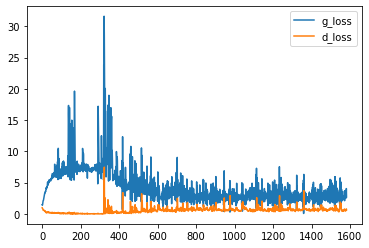

In [19]:
import pandas as pd

df = pd.DataFrame()
df['g_loss'] = lossesG
df['d_loss'] = lossesD
df.plot()

In [21]:
# utils.display_generator_output(netG, netG.latent_dim_size, rows=2, cols=7)